<a href="https://colab.research.google.com/github/amwld/blog/blob/master/TC_BERT_FAST_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# source: https://www.kaggle.com/keitakurita/bert-with-fastai-example

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
import random

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing import text, sequence
from keras.layers import Embedding, SpatialDropout1D
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.optimizers import RMSprop
import keras.backend as K
from keras.layers import Dense, Input, GRU, LSTM, Bidirectional, Dropout, CuDNNLSTM, CuDNNGRU
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Amanda directory structure
base_dir = '/content/drive/My Drive/BERT/BERT_Code_Input_Output/'
data_dir = base_dir + 'Data/'
model_dir = base_dir + 'Model_Output_FASTAI'

In [0]:
train = pd.read_csv(data_dir + 'train_cleaned_no_punkt.csv') 
test_labelled = pd.read_csv(data_dir + 'test_labelled_cleaned_no_punkt.csv') 
test_unlabelled = pd.read_csv(data_dir + 'test_unlabelled_cleaned_no_punkt.csv') 

In [0]:
train['mal'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) >= 1  
train.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)
train.comment_text.fillna("empty", inplace=True)

test_labelled['mal'] = test_labelled[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) >= 1  
test_labelled.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)
test_labelled.comment_text.fillna("empty", inplace=True)

test_unlabelled.comment_text.fillna("empty", inplace=True)

# CHANGE TRAIN AND TEST, MIX TO GET SIMILAR DISTRIBUTION
from sklearn.model_selection import train_test_split
RS = 42
X_train1, X_test1, y_train1, y_test1  = train_test_split(train.drop('mal', axis=1), train.mal, stratify=train.mal, test_size=0.29, random_state=RS )
X_train2, X_test2, y_train2, y_test2  = train_test_split(test_labelled.drop('mal', axis=1), test_labelled.mal, stratify=test_labelled.mal, test_size=0.29, random_state=RS)

X = np.concatenate((X_train1.comment_text, X_train2.comment_text))
y = np.concatenate((y_train1, y_train2))

X_test = np.concatenate((X_test1.comment_text, X_test2.comment_text))
y_test = np.concatenate((y_test1, y_test2))

In [0]:
# Parameters
MAXLEN = 128 # was 256
DROPOUT = 0
RS = 42
EPOCHS = 2
BATCHSIZE = 32 # was 32
MAX_LR=3e-5

FAST.AI


In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [0]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [10]:
!pip install pytorch-pretrained-bert

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=MAX_LR,
    epochs=EPOCHS,
    use_fp16=True,
    bs=BATCHSIZE,
    discriminative=False,
    max_seq_len=MAXLEN,
)

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

In [0]:
def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1} ' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
#from sklearn.model_selection import train_test_split

#DATA_ROOT = Path("..") / "input"

#train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv", "test.csv"]]
#val = train # we won't be using a validation set but you can easily create one using train_test_split

In [0]:
# create training and validation test set
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RS)

In [0]:
# better format for following functions
train = pd.DataFrame(np.stack((X_train, y_train), axis = 1)).rename(columns={0: "comment_text", 1: "malicious"})
val = pd.DataFrame(np.stack((X_val, y_val), axis = 1)).rename(columns={0: "comment_text", 1: "malicious"})
test = pd.DataFrame(np.stack((X_test, y_test), axis = 1)).rename(columns={0: "comment_text", 1: "malicious"})

In [0]:
# map bool to int
#train.malicious = train.malicious.astype(int)
#val.malicious = val.malicious.astype(int)
#test.malicious = test.malicious.astype(int)

In [0]:
config.testing = True

In [0]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [0]:
label_cols = ["malicious"]

# databunch = TextDataBunch.from_df(".", train, val, test,
#                   tokenizer=fastai_tokenizer,
#                   vocab=fastai_bert_vocab,
#                   include_bos=False,
#                   include_eos=False,
#                   text_cols="comment_text",
#                   label_cols=label_cols,
#                   bs=config.bs,
#                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
#              )

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [0]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [26]:
# this will produce a virtually identical databunch to the code above
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="comment_text",
                  label_cols="malicious",
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [27]:
databunch.show_batch()

text,target
[CLS] fair use rational ##e image witch hunter am ##on jp ##g thanks up ##loading or contributing to image witch hunter am ##on jp ##g i notice image page specifies that image being used under fair use but there no explanation or rational ##e to why its use in wikipedia articles constitutes fair use in addition to boiler ##plate fair use template you must also write out image description page,False
[CLS] images in sand ##box per usage non free images they can only be displayed syntax in article space in all other page spaces including sand ##box ##es link must be in image file ##name syntax per wikipedia non free content policy point such images been changed to not display result in following images to be orphaned image lb ##al ##b jp ##g image crime ##fighter ##sp p ##ng image,False
[CLS] bc wi ##ki ##pro ##ject user ##box been made made stab at user ##box check er out template user wi ##ki ##pro ##ject british columbia use user wi ##ki ##pro ##ject british columbia fu ##dge ##d around with colours and borders while tried to use colours taken from dog ##wood but wound up blue adjusting background not quite happy with bk ##gn ##d colour but better than grey transparent,False
[CLS] you curious eh well i not so adverse either being curious about nature certain edit patterns but in regards to matter more immediately at hand referenced ip ##cc document summary policy ##makers frankly not very well written summary its intended um not so aware audience makes all sorts ref ##s to particular time periods like reference period and but in terms projection does very clearly single out in graph,False
[CLS] missing citation at end first paragraph in part iii voyage to lap ##uta bal ##ni ##bar ##bi g ##lub ##b ##du ##b ##dr ##ib lu ##gg ##na ##gg and japan claims that jonathan swift knew that lap ##uta meant whore and this to attack reason and dei ##sm which i feel needs bit further explanation i found source but i think needs bit revision according to source lap ##uta,False


Model

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2) # here maybe part of problem

In [0]:
#loss_func = nn.BCEWithLogitsLoss()
#loss_func = nn.BCELoss()
loss_func = nn.CrossEntropyLoss()

In [0]:
#criterion = nn.BCELoss()
#target = target.unsqueeze(1)
#loss_func = criterion(input, unsqueeze(1))

In [0]:
from fastai.callbacks import *

learner = Learner(
    databunch,
    bert_model,
    loss_func = loss_func,
    model_dir = model_dir
    )
if config.use_fp16: learner = learner.to_fp16()

In [0]:
#learner.metrics=[accuracy, AUROC, Precision, Recall]
#learner.callback_fns = [CSVLogger]
#learner.path = model_dir

In [0]:
learner.lr_find()

epoch,train_loss,valid_loss,time


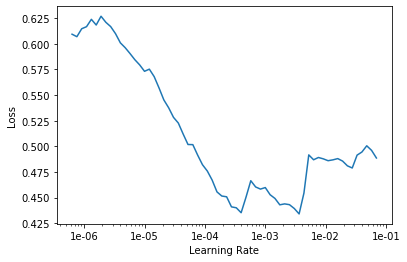

In [252]:
learner.recorder.plot()

In [253]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time
0,0.120862,0.119650,13:59
1,0.106379,0.102068,14:31
2,0.070263,0.114416,14:07
3,0.038533,0.155166,12:54


In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [0]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [0]:
probs = pd.DataFrame(test_preds).idxmax(axis = 1).astype(bool)

In [0]:
import sklearn
from sklearn import metrics

auc_pr = average_precision_score(y_test, probs)
auc_roc = roc_auc_score(y_test, probs)
f1 = sklearn.metrics.f1_score(y_test, probs)

In [303]:
print("AUC PR: ", round(auc_f,4))
print("AUC ROC: ", round(roc_f,4))
print("F1 score: ", round(f1,4))

AUC PR:  0.6373
AUC ROC:  0.8698
F1 score:  0.7827


In [0]:
probs.to_csv(model_dir + "/" + "FASTAI_predictions.csv", index=False)
pd.DataFrame(test_preds).to_csv(model_dir + "/" + "FASTAI_probabilities.csv", index=False)

In [1]:
f1

NameError: ignored